# Figures 1 & A1 for Frame et al. 2023 "On mass conservation..."
Added this figure for revision 2, so it is not in the main results notebook

In [1]:
import numpy as np
import pandas as pd
import pickle as pkl
import xarray as xr
import copy
import os
import sys
import metrics
import random
import scipy.stats as st
import matplotlib 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import mutual_info_score

In [2]:
def cm2inch(width: float, height: float) -> tuple:
    """Converts figure size from centimeters to inch.
    
    Parameters
    ----------
    width : float
        Width of figure in centimeters
    height : float
        Height of figure in centimeters
    
    Returns
    -------
    Tuple[float, float]
        Tuple containing width and height in inches
    """
    inch = 2.54
    return (width / inch, height / inch)

In [3]:
# Convert flow to   CFS mm -> ft     km^2 -> ft^2    hr->s
conversion_factor = 0.00328084 * 10763910.41671 / 3600 / 24

In [4]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [5]:
# Camels attributes with RI information
dataName = '../data/camels_attributes.csv'
# load the data with pandas
pd_attributes = pd.read_csv(dataName, sep=',', index_col='gauge_id')

# Add the basin ID as a 8 element string with a leading zero if neccessary
basin_id_str = []
for a in pd_attributes.index.values:
    basin_id_str.append(str(a).zfill(8))
pd_attributes['basin_id_str'] = basin_id_str

In [6]:
lstm_results_time_split1={}
lstm_results_time_split2={}
for forcing_type in ['nldas', 'daymet']:
    with open('./model_output_for_analysis/lstm_time_split1_{}_ens.p'.format(forcing_type), 'rb') as fb:
        lstm_results_time_split1[forcing_type] = pkl.load(fb)
    with open('./model_output_for_analysis/lstm_time_split2_{}.p'.format(forcing_type), 'rb') as fb:
        lstm_results_time_split2[forcing_type] = pkl.load(fb)

In [7]:
##########################################################################################################
# DO THE MASS TOTALS so we can compare the differences in forcing products
##########################################################################################################
forcing_products = ['nldas','daymet']

file_name_map = {'nldas':'nldas', 'daymet':'cida'}
precip_column_map = {'nldas':'PRCP(mm/day)', 'daymet':'prcp(mm/day)'}
tmax_column_map = {'nldas': 'Tmax(C)', 'daymet': 'tmax(C)'}
tmin_column_map = {'nldas': 'Tmin(C)', 'daymet': 'tmin(C)'}
srad_column_map = {'nldas': 'SRAD(W/m2)', 'daymet': 'srad(W/m2)'}

vp_column_map = {'nldas': 'Vp(Pa)', 'daymet': 'vp(Pa)'}

total_mass = {forcing_type:{time_split:{} for time_split in ['time_split1', 'time_split2']} for \
                       forcing_type in forcing_products}
    
mass_basin_list={}
    
for tsplt in ['time_split1', 'time_split2']:
    print('tsplt', tsplt)
    for forcing_type in forcing_products:

        print('forcing_type ',forcing_type)

        mass_basin_list[tsplt] = []

        forcing_dir = '/home/NearingLab/data/camels_data/basin_dataset_public_v1p2'+\
            '/basin_mean_forcing/{}_all_basins_in_one_directory/'.format(forcing_type)

        labelz={'precip':precip_column_map['nldas'], 'obs':'Observed'}
        flows = ['precip', 'obs']
        
        if tsplt == 'time_split2' and forcing_type == 'nldas':
            start_date = pd.Timestamp('1996-10-01')
            end_date = pd.Timestamp('2014-01-01')
            basin_list = list(lstm_results_time_split2[forcing_type].keys())[:-1]
        elif tsplt == 'time_split2' and forcing_type == 'daymet':
            start_date = pd.Timestamp('1996-10-01')
            end_date = pd.Timestamp('2014-01-01')
            basin_list = list(lstm_results_time_split2[forcing_type].keys())[:-1]
        else:
            start_date = pd.Timestamp('1989-10-01')
            end_date = pd.Timestamp('1999-09-30')
            basin_list = list(lstm_results_time_split1[forcing_type].keys())[:-1]

        first_basin = True

        for basin_0str in basin_list:
            basin_int = int(basin_0str)
#            print(basin_0str)

            #-------------------------------------------------------------------------------------------------
            # Reset the total mass to zero for this basin    
            total_mass[forcing_type][tsplt][basin_0str] = {flow:0 for flow in flows}
            imass=1
            #-------------------------------------------------------------------------------------------------


            #-------------------------------------------------------------------------------------------------
            # We need the basin area to convert to CFS, to interpolate the RI from LPIII
            basin_area = pd_attributes.loc[basin_int, 'area_geospa_fabric']
            basin_str = str(basin_int).zfill(8)
            #-------------------------------------------------------------------------------------------------

            
            #-------------------------------------------------------------------------------------------------
            # OBSERVATIONS
            if tsplt == 'time_split1':
                xrr = lstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].loc[start_date:end_date]
                flow_mm_obs = pd.DataFrame(data=xrr.values,index=xrr.datetime.values)
            if tsplt == 'time_split2':
                xrr = lstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].loc[start_date:end_date]
                flow_mm_obs = pd.DataFrame(data=xrr.values,index=xrr.date.values)
            #-------------------------------------------------------------------------------------------------
            # FORCING
            forcing = pd.read_csv(forcing_dir+basin_0str+f'_lump_{file_name_map[forcing_type]}_forcing_leap.txt', 
                                  delim_whitespace=True, header=3)
            if tsplt == 'time_split1':
                forcing = forcing.iloc[3560:7214]
            if tsplt == 'time_split2':
                forcing = forcing.iloc[6118:]
            forcing.index=pd.to_datetime((forcing.Year*10000+forcing.Mnth*100+forcing.Day).apply(str),format='%Y%m%d')
            #-------------------------------------------------------------------------------------------------

            #-------------------------------------------------------------------------------------------------
            # Make sure we are in a time period that all the flow members have values
            # If there is missin observations than we can't compare the mass of the observed with simulaitons
            skip_basin_because_missing_obs = False
            if tsplt == 'time_split1':
                obs_temp = lstm_results_time_split1[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].datetime
            if tsplt == 'time_split2':
                obs_temp = lstm_results_time_split2[forcing_type][basin_0str]['1D']['xr']['QObs(mm/d)_obs'].date
            if np.isnan(flow_mm_obs.loc[start_date:end_date].sum()[0]): 
                print("basin missing value: ", basin_0str)
                skip_basin_because_missing_obs = True

            #-------------------------------------------------------------------------------------------------
            # If there is missin observations than we can't compare the mass of the observed with simulaitons            
            if skip_basin_because_missing_obs:
    #            print("skipping basin {} because of missing observations".format(basin_0str))
                continue
            else:
                mass_basin_list[tsplt].append(basin_0str)

            total_mass[forcing_type][tsplt][basin_0str]['obs'] = flow_mm_obs.loc[start_date:end_date].sum()
            total_mass[forcing_type][tsplt][basin_0str]['precip'] = \
                forcing.loc[:, precip_column_map[forcing_type]].sum()
            total_mass[forcing_type][tsplt][basin_0str]['tmax'] = \
                forcing.loc[:, tmax_column_map[forcing_type]].mean()
            total_mass[forcing_type][tsplt][basin_0str]['tmin'] = \
                forcing.loc[:, tmin_column_map[forcing_type]].mean()
            total_mass[forcing_type][tsplt][basin_0str]['srad'] = \
                forcing.loc[:, srad_column_map[forcing_type]].mean()
            total_mass[forcing_type][tsplt][basin_0str]['vp'] = \
                forcing.loc[:, vp_column_map[forcing_type]].mean()
            
# _______________________________________________________________________
# Save the results.
# with open('total_mass_precip_obs.pkl', 'wb') as fb:
#     pkl.dump(total_mass, fb)

tsplt time_split1
forcing_type  nldas
forcing_type  daymet
tsplt time_split2
forcing_type  nldas
forcing_type  daymet


In [8]:
forcing

,Year,Mnth,Day,Hr,dayl(s),prcp(mm/day),srad(W/m2),swe(mm),tmax(C),tmin(C),vp(Pa)
1996-10-01,1996,10,1,12,41126.4,0.00,373.07,0.0,26.13,7.40,376.52
1996-10-02,1996,10,2,12,41126.4,0.00,352.20,0.0,25.13,7.97,422.67
1996-10-03,1996,10,3,12,40780.8,0.00,333.23,0.0,23.78,7.86,442.25
1996-10-04,1996,10,4,12,40780.8,0.00,315.55,0.0,22.42,7.59,468.80
1996-10-05,1996,10,5,12,40435.2,0.00,332.35,0.0,23.09,7.05,423.28
...,...,...,...,...,...,...,...,...,...,...,...
2014-12-27,2014,12,27,12,32140.8,0.00,195.69,0.0,6.49,-1.28,558.13
2014-12-28,2014,12,28,12,32140.8,2.93,137.44,0.0,5.67,-0.64,584.76
2014-12-29,2014,12,29,12,32140.8,2.26,158.42,0.0,3.47,-2.56,507.23
2014-12-30,2014,12,30,12,32140.8,4.38,170.96,0.0,2.00,-6.56,375.60


In [9]:

for b in pd_attributes['basin_id_str'].values:
    
    for forcing_type in ['nldas', 'daymet']:
        
        for time_split in ['time_split1', 'time_split2']:
            
            if b in list(total_mass[forcing_type][time_split].keys()):
                
                Q = total_mass[forcing_type][time_split][b]['obs'][0]
                P = total_mass[forcing_type][time_split][b]['precip']
                Tmax = total_mass[forcing_type][time_split][b]['tmax']
                Tmin = total_mass[forcing_type][time_split][b]['tmin']
                srad = total_mass[forcing_type][time_split][b]['srad']
                
                pd_attributes.loc[int(b),f"qsum_ts{time_split[-1]}"] = Q
    
                pd_attributes.loc[int(b),f"psum_{forcing_type}_ts{time_split[-1]}"] = P
        
                pd_attributes.loc[int(b),f"rr_{forcing_type}_ts{time_split[-1]}"] = Q/P
            
                pd_attributes.loc[int(b),f"tmax_{forcing_type}_ts{time_split[-1]}"] = Tmax
                pd_attributes.loc[int(b),f"tmin_{forcing_type}_ts{time_split[-1]}"] = Tmin

                pd_attributes.loc[int(b),f"srad_{forcing_type}_ts{time_split[-1]}"] = srad

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


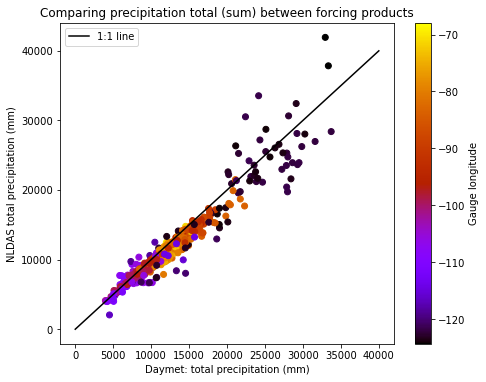

In [37]:
fig = plt.figure(figsize=cm2inch(19,15))
ax = fig.add_subplot()
sc = plt.scatter(pd_attributes[f'psum_daymet_ts1'], 
            pd_attributes[f'psum_nldas_ts1'],
            c=pd_attributes['gauge_lon'], cmap='gnuplot')
plt.plot([0,40000],[0,40000],"k", label="1:1 line")
plt.xlabel("Daymet: total precipitation (mm)")
plt.ylabel("NLDAS total precipitation (mm)")
plt.title(f"Comparing precipitation total (sum) between forcing products")
cbar = plt.colorbar(sc)
cbar.set_label('Gauge longitude')    
plt.legend()
plt.savefig('../figs/revision_2/figure_1.png', dpi=600)
plt.savefig('../figs/revision_2/figure_1.eps', dpi=600, format="eps")
plt.show()
plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


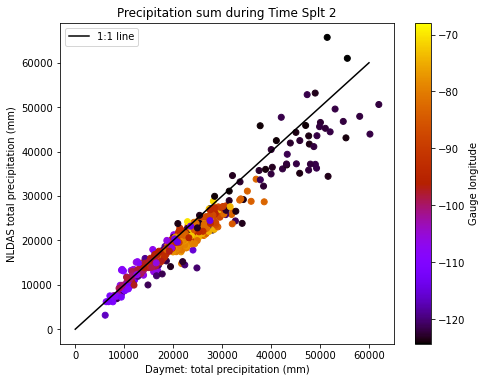

In [36]:
fig = plt.figure(figsize=cm2inch(19,15))
ax = fig.add_subplot()
sc = plt.scatter(pd_attributes[f'psum_daymet_ts2'], 
            pd_attributes[f'psum_nldas_ts2'],
            c=pd_attributes['gauge_lon'], cmap='gnuplot')
plt.plot([0,60000],[0,60000],"k", label="1:1 line")
plt.xlabel("Daymet: total precipitation (mm)")
plt.ylabel("NLDAS total precipitation (mm)")
plt.title(f"Precipitation sum during Time Splt {ts[-1]}")
cbar = plt.colorbar(sc)
cbar.set_label('Gauge longitude')    
plt.legend()
plt.savefig('../figs/revision_2/png/figure_A1.png', dpi=600)
plt.savefig('../figs/revision_2/eps/figure_A1.eps', dpi=600, format="eps")
plt.show()
plt.close()